In [2]:
# importing libraries
import numpy as np
from math import ceil, log2
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import QasmSimulator  
from qiskit.visualization import plot_histogram
# try the “modern” import first…
try:
    from qiskit.circuit.library import DiagonalGate
# …fall back if you’re on an older Terra
except ImportError:
    from qiskit.circuit.library.generalized_gates import DiagonalGate


In [3]:
# 1. Problem parameters (those can be changed think them as constants)
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required to represent N states
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of Trotter steps (Trotterization depth)
dt      = t_tot / r # Time step for each Trotter slice
hbar    = 1.0 # Planck's constant (often set to 1 in quantum computing contexts for simplicity)

In [4]:
# 2. Precompute potential V(x)
x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions from 0 to 1 (exclusive of 1)
V_array = 0.5 * (np.sin(2*np.pi*x_vals))**2  # this will be our own Hamiltionian expressions


In [5]:

# 3. Build QFT & inverse-QFT circuits
# QFT is used to switch between position and momentum bases.
# do_swaps=True ensures the output qubits are in standard order.

qft     = QFT(n_q, do_swaps=True).decompose()
inv_qft = qft.inverse() # Inverse QFT to switch back

def add_kinetic_step(qc: QuantumCircuit):

    qc.append(qft, range(n_q)) # Apply QFT to move to momentum basis
    
    # Calculate the complex phases for each computational basis state |k> (momentum state)
    kinetic_phases = []
    for k in range(2**n_q): # k iterates through all possible integer values represented by n_q qubits
        # The kinetic energy is proportional to k^2 in momentum space
        phi_k = (hbar**2 * k**2 / 2) * dt
        kinetic_phases.append(np.exp(-1j * phi_k)) # Calculate e^(-i * phi_k)
    
    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(kinetic_phases), range(n_q))
    qc.append(inv_qft, range(n_q)) # Apply inverse QFT to move back to position basis

def add_potential_step(qc: QuantumCircuit):

    # Potential well (this step will be more complicated)
    # Calculate the complex phases for each computational basis state |x> (position state)
    potential_phases = []
    for x_idx in range(N): # x_idx iterates through all possible integer values representing positions
        # The potential energy V(x) is directly V_array[x_idx]
        # The angle for time evolution is V(x) * dt
        angle_x = V_array[x_idx] * dt
        potential_phases.append(np.exp(-1j * angle_x)) # Calculate e^(-i * angle_x)
    
    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(potential_phases), range(n_q))


In [6]:
# 4. Build the main Trotter circuit
# Initialize a quantum circuit with n_q qubits and n_q classical bits for measurement
qc = QuantumCircuit(n_q, n_q)

# 4.1 Initial state preparation
# For a general simulation, you would prepare your initial wavepacket here.
for i in range(n_q):
    qc.h(i)

# 4.2 Time evolution using Trotter steps
# This implements the first-order Trotter-Suzuki decomposition:
for _ in range(r):
    add_kinetic_step(qc)   # Apply kinetic energy evolution
    add_potential_step(qc) # Apply potential energy evolution

qc.barrier() # Optional: Adds a visual barrier in the circuit diagram for clarity
qc.measure(range(n_q), range(n_q)) # Measure all quantum bits and store results in classical bits


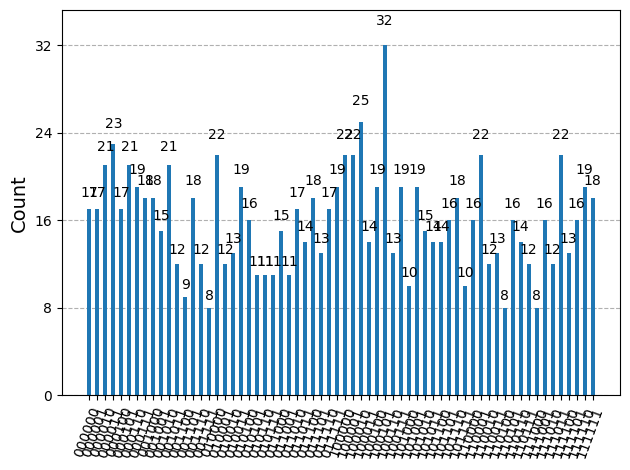

In [7]:
# 5. Run on QasmSimulator
backend     = QasmSimulator() 
qc_compiled = transpile(qc, backend) # Optimize the circuit for the specific backend
job         = backend.run(qc_compiled, shots=1024) # Run the simulation with 1024 measurement shots
result      = job.result() # Retrieve the results of the simulation
counts      = result.get_counts() # Get the dictionary of measurement outcomes (e.g., {'000': 500, '001': 524})

# 6. Plot |ψ(x)|²
plot_histogram(counts)

{'100011': 14, '111000': 8, '110100': 8, '001111': 8, '110101': 16, '010000': 22, '100110': 13, '000100': 17, '111110': 19, '100000': 22, '101000': 10, '001100': 9, '101100': 14, '100111': 19, '101110': 18, '010100': 16, '000111': 18, '111100': 13, '001000': 18, '111010': 12, '111101': 16, '100010': 25, '011111': 19, '010001': 12, '010110': 11, '010111': 11, '001101': 18, '110110': 14, '010011': 19, '001110': 12, '011001': 11, '110111': 12, '101001': 19, '000011': 23, '101101': 16, '110011': 13, '111111': 18, '001011': 12, '011011': 14, '001001': 15, '110000': 16, '100101': 32, '000001': 17, '101011': 14, '110010': 12, '011010': 17, '100001': 22, '111001': 16, '000110': 19, '011000': 15, '100100': 19, '001010': 21, '011101': 13, '110001': 22, '000101': 21, '000000': 17, '011100': 18, '101111': 10, '000010': 21, '011110': 17, '101010': 15, '010101': 11, '010010': 13, '111011': 22}
Total shots = 1024


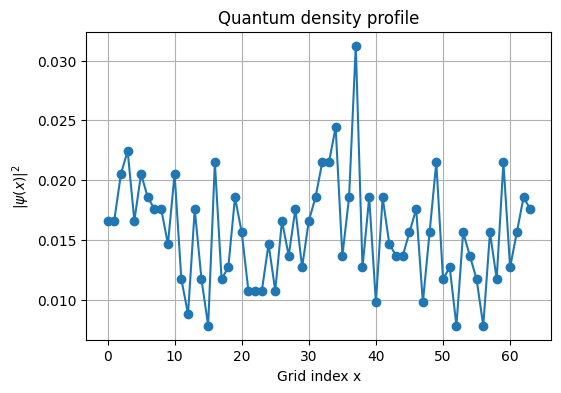

In [8]:
print(counts)
# counts is a dict { bitstring: int_count }
total_shots = sum(counts.values())
print(f"Total shots = {total_shots}")

# Build a list of (x, P(x)) pairs
probs = []
for bitstr, cnt in counts.items():
    x = int(bitstr, 2)        # convert '0101' → 5
    p = cnt / total_shots     # probability estimate
    probs.append((x, p))

# Sort by x
probs.sort(key=lambda pair: pair[0])

xs, ps = zip(*probs)  # two tuples: positions and probabilities

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(xs, ps, marker='o', linestyle='-')
plt.xlabel('Grid index x')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Quantum density profile')
plt.grid(True)
plt.show()